In [41]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  

In [42]:
data_train=pd.read_csv('train.csv')  

In [43]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [44]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [45]:
from sklearn.ensemble import RandomForestRegressor

# use random forest to fill the missing ages
def set_missing_ages(df):

    # Put these data into Random Forest Regressor
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y = known_age[:, 0]
    X = known_age[:, 1:]

    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    predictedAges = rfr.predict(unknown_age[:, 1::])
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

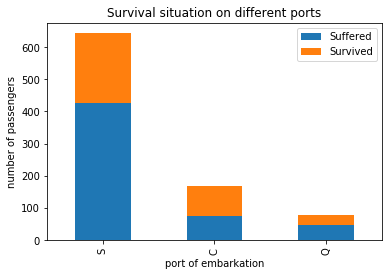

In [46]:
fig = plt.figure()
fig.set(alpha=0.2)  

Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df=pd.DataFrame({'Survived':Survived_1, 'Suffered':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title("Survival situation on different ports")
plt.xlabel("port of embarkation") 
plt.ylabel("number of passengers") 

plt.show()

In [47]:
# convert the data in "Cabin", "Embarked", "Sex", "Pclass" to binary
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')
df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [48]:
#scale of "Age" and "Fare"
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df['Age'].values.reshape(-1, 1))
df['Age_scaled']=age_scale_param.transform(df['Age'].values.reshape(-1, 1))

fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1, 1))
df['Fare_scaled'] = fare_scale_param.transform(df['Fare'].values.reshape(-1, 1))

In [49]:
# cluster "Age" by 10
age_segmentation=[0,10,20,30,40,50,60,70,80]
for j in range(1, len(age_segmentation)):
    age = np.zeros((891,1),dtype=np.uint8)
    for i in range(891):
        if df['Age'][i]<=age_segmentation[j] and df['Age'][i]>age_segmentation[j-1]:
            age[i]=1
    df['Age_'+str(age_segmentation[j])]=age

df.drop(['Age_scaled'], axis=1, inplace=True)

In [50]:
# Logistic Regression
from sklearn import linear_model
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
y = train_np[:, 0]
X = train_np[:, 1:]
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
clf.fit(X, y)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [51]:
data_test = pd.read_csv("test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0

# convert testing data as training data
# use random forest to fill the missing age
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

## convert the data in "Cabin", "Embarked", "Sex", "Pclass" to binary
data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')
df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)

# scale the data in "Age" and "Fare"
age_scale_param = scaler.fit(df_test['Age'].values.reshape(-1, 1))
df_test['Age_scaled'] = age_scale_param.transform(df_test['Age'].values.reshape(-1, 1))
fare_scale_param = scaler.fit(df_test['Fare'].values.reshape(-1, 1))
df_test['Fare_scaled'] = fare_scale_param.transform(df_test['Fare'].values.reshape(-1, 1))
df_test=df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)

#Group "Age" by 10
age_segmentation=[0,10,20,30,40,50,60,70,80]
for j in range(1, len(age_segmentation)):
    age = np.zeros((418,1),dtype=np.uint8)
    for i in range(418):
        if df_test['Age'][i]<=age_segmentation[j] and df_test['Age'][i]>age_segmentation[j-1]:
            age[i]=1
    df_test['Age_'+str(age_segmentation[j])]=age

df_test.drop(['Age_scaled'], axis=1, inplace=True)

In [52]:
# predict using Logistic Regression
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions.csv", index=False)

In [53]:
pd.DataFrame({"columns":list(train_df.columns)[1:], "coefficient":list(clf.coef_.T)})

,coefficient,columns
0,[-0.39111354529751285],SibSp
1,[-0.1885639736819222],Parch
2,[-0.3312802999888071],Cabin_No
3,[0.5475744960492058],Cabin_Yes
4,[0.21556032017632767],Embarked_C
5,[0.11256681696449158],Embarked_Q
6,[-0.2626189050084667],Embarked_S
7,[1.4418443615470204],Sex_female
8,[-1.2255501654866012],Sex_male
9,[0.5537212781830293],Pclass_1


In [54]:
# have a look at cross validation score
from sklearn.model_selection import cross_val_score
all_data = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
X = all_data.as_matrix()[:,1:]
y = all_data.as_matrix()[:,0]

print( cross_val_score(clf, X, y, cv=5) )

[0.81005587 0.77653631 0.7752809  0.78651685 0.81920904]


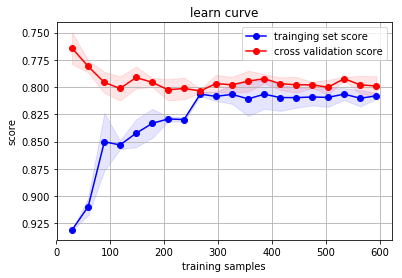

(0.8005474084561006, 0.020565092723675682)

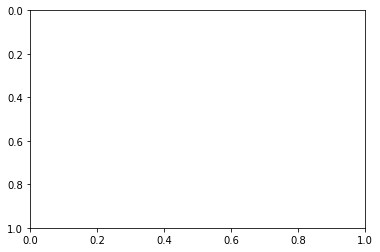

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# draw learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):

    #estimator : classifier
    #title : title of the figure
    #X : input feature
    #y : target vector
    #ylim : set the min and max value of y-axis 
    #cv : the number we want to divide the data when implementing cross-validation

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("training samples")
        plt.ylabel("score")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="trainging set score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="cross validation score")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(clf, "learn curve", X, y)

In [59]:
#SVM with gaussian kernel
from sklearn import svm
svc2 = svm.SVC(kernel='rbf', gamma=0.1)
svc2.fit(X, y)
training_accuracy = svc2.fit(X, y).score(X, y)

print( "training accuracy(gaussian kernel):" + str(training_accuracy) )
svm_predict2 = svc2.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':svm_predict2.astype(np.int32)})
result.to_csv("SVM_predictions.csv", index=False)


training accuracy(gaussian kernel):0.835016835016835


In [57]:
# Random Forest
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
RF = RandomForestClassifier(random_state=1, n_estimators=15, min_samples_split=4, min_samples_leaf=2)

RF.fit(X,y)
RF_accuracy=RF.score(X,y)
print( "training accuracy"+ str(RF_accuracy) )
RF_prediction = RF.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':RF_prediction.astype(np.int32)})
result.to_csv("RF_predictions.csv", index=False)


training accuracy0.8866442199775533


In [58]:
#Ensembles
LR_predict=pd.read_csv('logistic_regression_predictions.csv') 
SVM_predict=pd.read_csv('SVM_predictions.csv') 
RF_predict=pd.read_csv('RF_predictions.csv') 
p1=LR_predict['Survived'].values.reshape(-1,1)
p2=SVM_predict['Survived'].values.reshape(-1,1)
p3=RF_predict['Survived'].values.reshape(-1,1)
p4=[]
for i in range(len(p1)):
    average=(p1[i]+p2[i]+p3[i])/3.0
    if average>0.5:
        p4.append(1)
    else:
        p4.append(0)

result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':np.array(p4)})
result.to_csv("ensemble.csv", index=False)